# Registration workshop 1
## 17th January 2019
### Python version

[Open in Colab](https://colab.research.google.com/github/meganzoe/ipmi-registration/blob/master/registration_workshop_1_example_solution.ipynb)

Required packages: `scikit-image` , `scipy`($\geqslant$0.14), `numpy`, `matplotlib`

First we will set up colab so that the data and `utils.py` script can be loaded. If you are not running this notebook through Colab you can comment out this first block.

In [ ]:
!git clone https://github.com/meganzoe/ipmi-registration
import os
os.chdir('ipmi-registration')

Then load the 2D lung MRI stored in lung_MRI_slice.png using the python library: `scikit-image`.

In [30]:
import skimage.io
lung = skimage.io.imread('lung_MRI_slice.png')

The image is stored as unsigned 8-bit integers:

In [31]:
print(lung.dtype)

uint8


You should convert `lung` to double precision so that errors do not occur when processing the image. 

In [32]:
import numpy as np
img = np.double(lung)

Numpy arrays used 'matrix' coordinates - the first cooridnate is the row number (i.e. the y coordinate) and the second is the column number (i.e. the x coordinate). The rows are also numbered from top to bottom.
We need to reoritentate the image - from (y-axis 1st dim, 0 at top) to
'standard orientation' (y-axis 2nd dim, 0 at bottom) - so that it can be dispalyed 
using the `dispImage` function with the origin in the lower left.

When the image is read in using `scikit-image`'s `imread` function it is initially stored in ‘ij’ coordinates – therefore, before proceeding it is necessary to re-orientate it into ‘standard orientation’. This can be done by first flipping along the second dimension (moving the first pixel from the top to the bottom of the image) and taking the transpose of the matrix (switching x and y dimensions)

In [33]:
img = np.flipud(img)
img = img.T

Now lets view the image using the `dispImage` function from `utils.py` which should be in the same folder as this notebook.

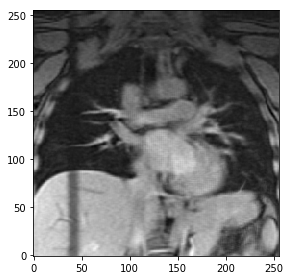

In [34]:
from utils import dispImage
dispImage(img)

Create an affine matrix representing a translation by 10 pixels in the `x` direction and 20 pixels in the `y` direction. Create a deformation field for the transformation using the provided `defFieldFromAffineMatrix` function, and then resample the image with the deformation field using the provided `resampImageWithDefField` function within `utils.py`.

In [6]:
T = np.matrix([[1, 0, 10],[0,1,20],[0,0,1]])
print(T)

[[ 1  0 10]
 [ 0  1 20]
 [ 0  0  1]]


Calculate the deformation field from the translation matrix:

In [7]:
from utils import defFieldFromAffineMatrix, resampImageWithDefField

num_pix_x, num_pix_y = img.shape
def_field = defFieldFromAffineMatrix(T, num_pix_x, num_pix_y)

Resample and display the image. The function resampImageWithDefField uses linear interpolation by default; other supported methods for `scipy`'s interpn function are 'nearest' and 'splinef2d'.

Does it appear as expected? Note, the `resampleImageWithDefField` function uses pull-interpolation, so the image will appear to have been transformed by the inverse of the transformation in the affine matrix. 

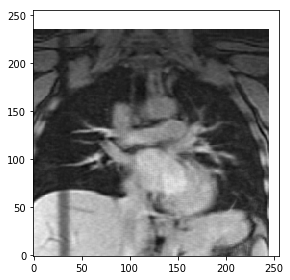

In [9]:
I_T_1 = resampImageWithDefField(img, def_field, interp_method='linear')
dispImage(I_T_1)

Check what value has been assigned to pixels that were originally outside the image. This is known as the ‘padding value’ or ‘extrapolation value’. A value of NaN (not a number) is often used to indicate that the true value for these pixels is unknown, and therefore they should be ignored when calculating similarity measures during image registration.

In [13]:
# print the value of the image I_T_1 in the top right corner
print(I_T_1[-1,-1])

nan


Resample the image again using nearest neighbour interpolation and cubic spline interpolation and display the resulting images. Do the different interpolation methods give different results? It may be useful to use difference images (one minus the other) to assess this. 

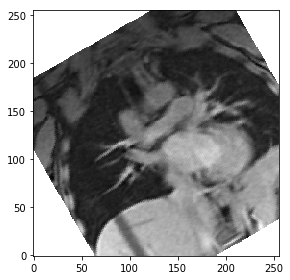

In [23]:
I_T_2 = resampImageWithDefField(img, def_field, interp_method='nearest')
dispImage(I_T_2)

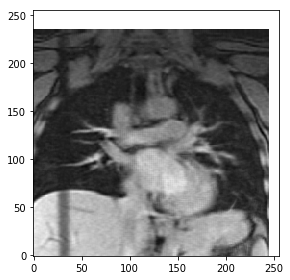

In [8]:
I_T_3 = resampImageWithDefField(img, def_field, interp_method='splinef2d')
dispImage(I_T_3)

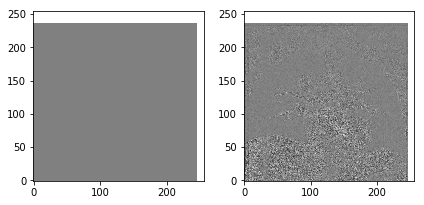

In [11]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)
dispImage(I_T_1 - I_T_2, ax = ax1)
dispImage(I_T_1 - I_T_3, ax = ax2)

What about if you now use a translation of 10.5 pixels in the x direction, and 20.5 pixels in the y direction?
Make sure you understand why you get the results that you do (if you are not sure ask one of the lab assistants).

Note – the transformed images may not have exactly the same intensity ranges as the original images due to interpolation and pixels moving outside of the image. This can cause unintentional differences in appearance if the images are displayed using their full intensity ranges (which is the default behaviour with the `dispImage` function). Therefore, it is often a good idea to ensure exactly the same intensity range is used when displaying and comparing different images (e.g. the intensity range of the original image). This can be done using the `int_lims` input to the dispImage function.

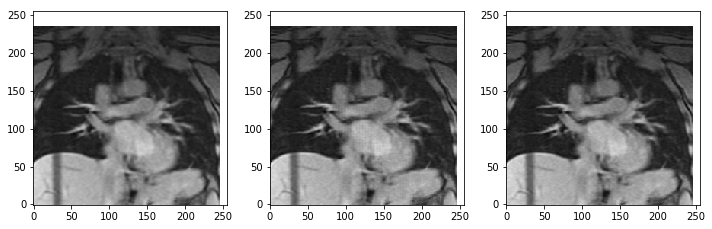

In [14]:
T = np.matrix([[1, 0, 10.5],[0,1,20.5],[0,0,1]])
def_field = defFieldFromAffineMatrix(T, num_pix_x, num_pix_y)
I_T_1 = resampImageWithDefField(img, def_field, interp_method='linear')
I_T_2 = resampImageWithDefField(img, def_field, interp_method='nearest')
I_T_3 = resampImageWithDefField(img, def_field, interp_method='splinef2d')
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (10,7))
dispImage(I_T_1, [np.min(img), np.max(img)], ax = ax1)
dispImage(I_T_2, [np.min(img), np.max(img)], ax = ax2)
dispImage(I_T_3, [np.min(img), np.max(img)], ax = ax3)

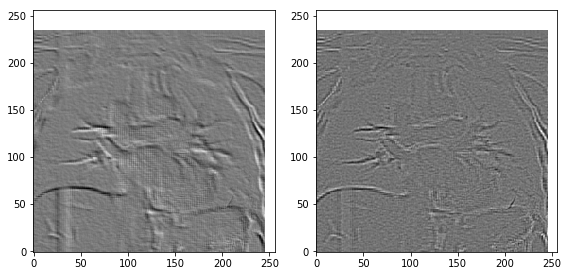

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (8,6))
dispImage(I_T_1 - I_T_2, ax = ax1)
dispImage(I_T_1 - I_T_3, ax = ax2)

Write a function that will calculate the affine matrix corresponding to a rotation about a point, P. The inputs to the function should be the angle of rotation (in degrees) and the coordinates of the point. 

In [37]:
from utils import affineMatrixForRotationAboutPoint
R = affineMatrixForRotationAboutPoint(5, [127.5, 127.5])
print(R)

[[  0.9961947   -0.08715574  11.59753319]
 [  0.08715574   0.9961947  -10.62718121]
 [  0.           0.           1.        ]]


Use the above function to calculate the affine matrix for an anticlockwise rotation of 5 degrees about the centre of the image.
Note – the image has an even number of pixels in each dimension, so the centre of the image will not be the centre of a pixel. The width and height of the image referred to in the lecture slides are the width and height from the centre of the first pixel to the centre of the last pixel, i.e. width = number of pixels in x – 1, height = number of pixels in y – 1.

Create a deformation field from the affine matrix above and use it to resample the image using linear interpolation. Now apply the same transformation to the transformed image. Repeat this 72 times so that the image will appear to rotate a full 360 degrees.
Display the results at periodic intervals. 

What do you notice? 

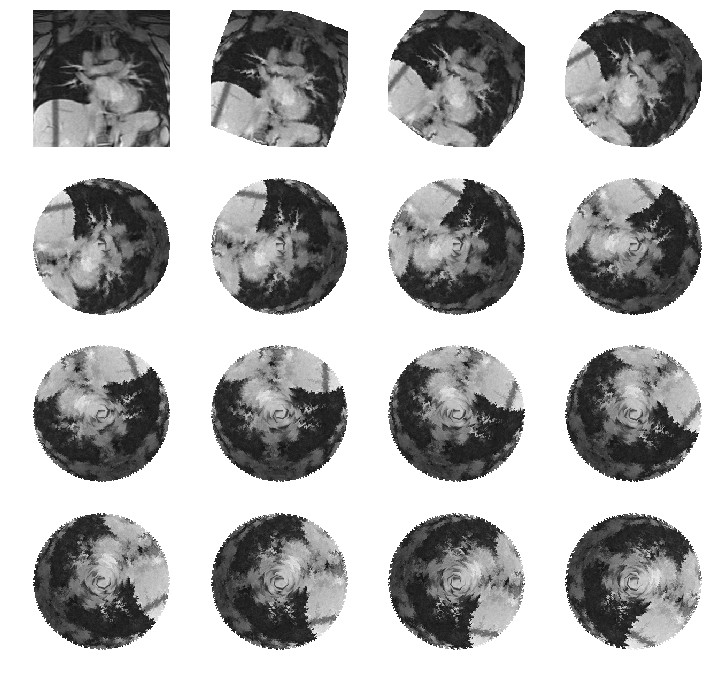

In [39]:
def stackImages(I_R, def_field, frames = 72):
    nx, ny = I_R.shape
    nz = frames
    I_R_all= np.zeros((nx,ny,nz))
    for n in range(nz):
        if n != 0:
            I_R_all[:,:,n] = resampImageWithDefField(I_R_all[:,:,n-1], def_field, 'linear')
        else:
            I_R_all[:,:,0] = I_R
    return I_R_all

def_field = defFieldFromAffineMatrix(R, img.shape[0], img.shape[1])
I_R = img
I_R_all = stackImages(I_R, def_field)
fig, axs = plt.subplots(figsize=(10,10),nrows = 4, ncols = 4)
for index, ax in enumerate(axs.flatten()):
    i = index * int((72./16))
    I_R = I_R_all[:,:,i]
    dispImage(I_R, ax = ax)
    ax.axis('off')

You will notice that the image gets smaller and smaller as it rotates. This is because of the NaN padding values – when a pixel value is interpolated from one or more NaN values it also gets set to NaN, so the pixels at the edge of the image keep getting set to NaN, and the image gets smaller after each rotation. 

To prevent this replace the NaN values in the transformed image with 0s before applying the next rotation (this is effectively using a padding value of 0 rather than NaN).

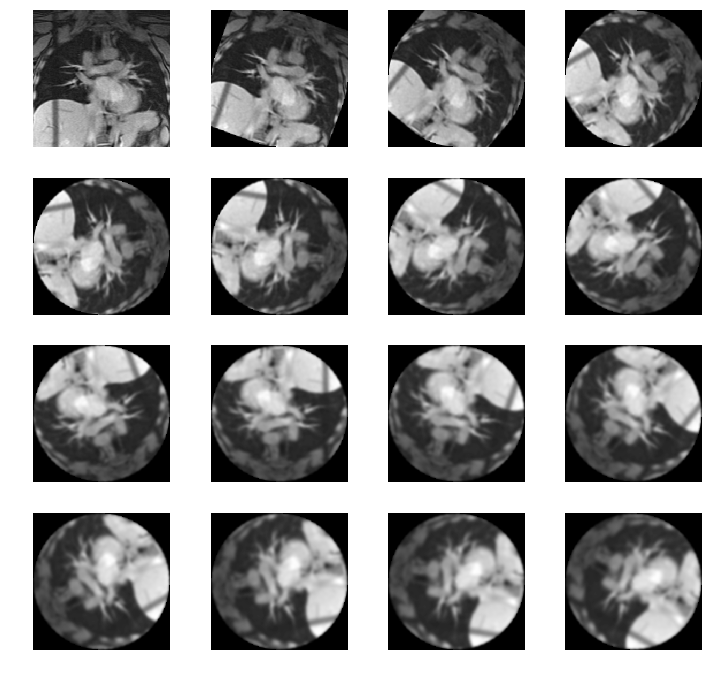

In [19]:
def stackImagesReplaceNans(I_R, def_field, frames = 72):
    nx, ny = I_R.shape
    nz = frames
    I_R_all= np.zeros((nx,ny,nz))
    for n in range(nz):
        if n != 0:
            I_R_all[:,:,n] = resampImageWithDefField(I_R_all[:,:,n-1], def_field, 'linear')
            # convert the locations of the NaNs to 0. 
            I_R_all[:,:,n][np.isnan(I_R_all[:,:,n])] = 0
        else:
            I_R_all[:,:,0] = I_R
            # convert the locations of the NaNs to 0. 
            I_R_all[:,:,0][np.isnan(I_R_all[:,:,0])] = 0
    return I_R_all

def_field = defFieldFromAffineMatrix(R, img.shape[0], img.shape[1])
I_R = img
I_R_all = stackImagesReplaceNans(I_R, def_field)
fig, axs = plt.subplots(figsize=(10,10),nrows = 4, ncols = 4)
for index, ax in enumerate(axs.flatten()):
    i = index * int((72./16))
    I_R = I_R_all[:,:,i]
    dispImage(I_R, ax = ax)
    ax.axis('off')

You will notice that the corners of the image still get ‘rounded off’ as it rotates so that it has become a circle after rotating 90 degrees. Do you understand why this happens?

Now repeat the above using nearest neighbour and cubic interpolation and compare the final results to the result obtained using linear interpolation.
Now experiment with using different angles (both smaller and larger) and rotating about a different point.
Make sure you understand all the results you get.

The blurring artefacts and the ‘rounding off’ of the images seen above are caused by multiple re-samplings of the image. This can be prevented by composing the rotations and applying the resulting transformation to the original image instead of the transformed image. Use this approach to create animations of the rotating image as above, but which do not suffer from blurring artefacts or ‘rounding off’ of the images. Try this using nearest neighbour, linear, and cubic interpolation.

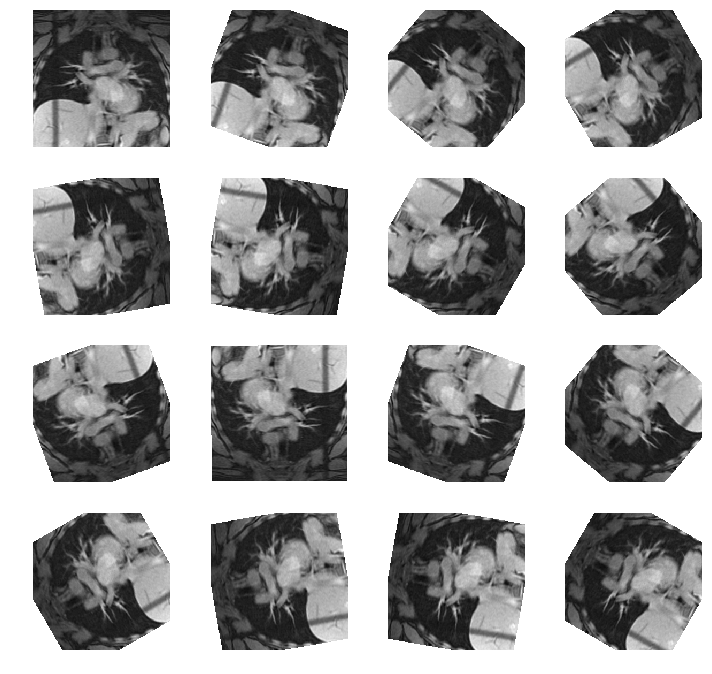

In [18]:
def composeRotations(img, R_comp, R, frames = 72):
    nx, ny = img.shape
    nz = frames
    I_R_all= np.zeros((nx,ny,nz))
    for n in range(nz):
        if n != 0:
            R_comp = R_comp * R
            def_field = defFieldFromAffineMatrix(R_comp, nx, ny)
            I_R_all[:,:,n] = resampImageWithDefField(img, def_field)
        else:
            I_R_all[:,:,0] = img
    return I_R_all

R_comp = np.eye(3)
I_R_all = composeRotations(img, R_comp, R)
fig, axs = plt.subplots(figsize=(10,10),nrows = 4, ncols = 4)
for index, ax in enumerate(axs.flatten()):
    i = index * int((72./16))
    I_R = I_R_all[:,:,i]
    dispImage(I_R, ax = ax)
    ax.axis('off')

As discussed in the lectures, it is possible to resample an image using push-interpolation, but it is far less computationally efficient than using pull-interpolation.

Create an affine matrix representing a rotation by -30 degrees about the point 150,150, and use this to calculate the corresponding deformation field. Use the `resampImageWithDefFieldPushInterp` function to create the transformed image using push-interpolation. Is the result as expected?

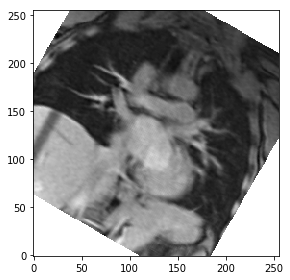

In [20]:
from utils import resampImageWithDefFieldPushInterp
R = affineMatrixForRotationAboutPoint(-30, [150, 150])
def_field = defFieldFromAffineMatrix(R, num_pix_x, num_pix_y)
I_R_push = resampImageWithDefFieldPushInterp(img, def_field)
dispImage(I_R_push, [np.nanmin(img), np.nanmax(img)])

Now use pull-interpolation (i.e. the `resampImageWithDefField` function) to create the same result. Compare the results – you should notice that they appear very similar, but if you display a difference image between the results you will see some small differences.

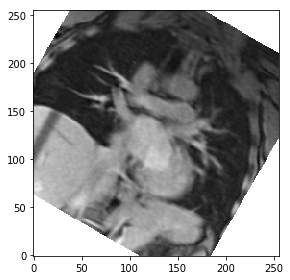

In [21]:
R_inv = np.linalg.inv(R)
def_field_inv = defFieldFromAffineMatrix(R_inv, num_pix_x, num_pix_y)
I_R_pull = resampImageWithDefField(img, def_field_inv)
dispImage(I_R_pull, [np.nanmin(img), np.nanmax(img)])

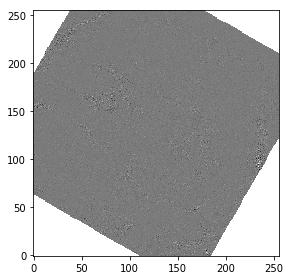

In [22]:
dispImage(I_R_pull - I_R_push)

The main difference is in the computation time. Re-create the rotating image animation above but using push-interpolation and you will notice the difference!

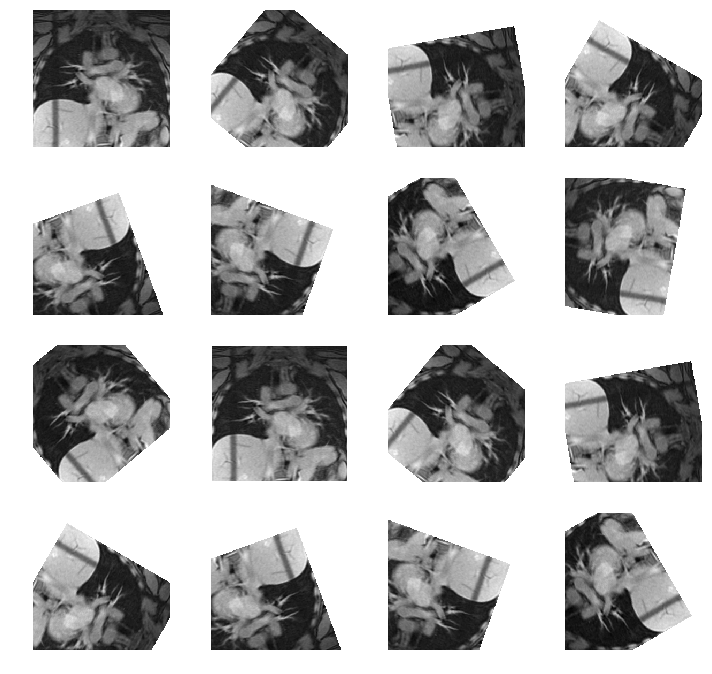

In [24]:
def composeRotationsPushInterp(img, R_comp, R, frames = 72):
    nx, ny = img.shape
    nz = frames
    I_R_all= np.zeros((nx,ny,nz))
    for n in range(nz):
        if n != 0:
            R_comp = R_comp * R
            def_field = defFieldFromAffineMatrix(R_comp, nx, ny)
            I_R_all[:,:,n] = resampImageWithDefFieldPushInterp(img, def_field)
        else:
            I_R_all[:,:,0] = img
    return I_R_all

R = affineMatrixForRotationAboutPoint(-10, [100, 100])
R_comp = np.eye(3)
I_R_all = composeRotationsPushInterp(img, R_comp, R)
fig, axs = plt.subplots(figsize=(10,10),nrows = 4, ncols = 4)
for index, ax in enumerate(axs.flatten()):
    i = index * int((72./16))
    I_R = I_R_all[:,:,i]
    dispImage(I_R, ax = ax)
    ax.axis('off')